In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as dr
import matplotlib.pyplot as plt
# Librería para mejorar la visualización del gráfico
plt.style.use('seaborn-darkgrid')

In [2]:
# Seleccionamos el activo a analizar y las fechas de estudio
from datetime import date
Activo = 'SPY'
FechaInicio = '1993-02-01'
FechaFinal = date.today()
# Descargamos la serie y mostramos el Tail.
df = dr.data.get_data_yahoo(Activo,start=FechaInicio,end=FechaFinal)
df = df[~df.index.duplicated()] # Eliminamos los duplicados en el índice (Problemas con criptomonedas)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-03,309.640015,307.130005,308.649994,309.549988,73941700.0,309.549988
2019-12-04,312.119995,310.320007,310.700012,311.459991,49080000.0,311.459991
2019-12-05,312.250000,310.579987,312.230011,312.019989,40709000.0,312.019989
2019-12-06,315.309998,314.109985,314.119995,314.869995,48927000.0,314.869995
2019-12-09,315.179993,313.799988,314.440002,313.880005,34838500.0,313.880005


In [3]:
# Creamos una nueva columna que recoge el cambio porecentual del precio de Cierre.
# Mingo - Esto me chirría, el renmdiento Aritmético, solo está bien para decir que un 
# fondo o activo ha ganado tanto, pero en cuanto se empeice a trabajar con él . . . malo.
#df["R. Aritmetico"] = df["Adj Close"].pct_change() 
#df.tail()
#(np.log(spx.Close) - np.log(spx.Close.shift(1)))*100
df["Rend_log"] = (np.log(df["Adj Close"]) - np.log(df["Adj Close"].shift(1)))*100  #miltiplico x 100 para tenerlo en %
df = df.dropna()

In [4]:
df

,High,Low,Open,Close,Volume,Adj Close,Rend_log
Date,,,,,,,
1993-02-02,44.375000,44.125000,44.218750,44.343750,201300.0,26.829773,0.211648
1993-02-03,44.843750,44.375000,44.406250,44.812500,529400.0,27.113388,1.051543
1993-02-04,45.093750,44.468750,44.968750,45.000000,531500.0,27.226835,0.417545
1993-02-05,45.062500,44.718750,44.968750,44.968750,492100.0,27.207933,-0.069448
1993-02-08,45.125000,44.906250,44.968750,44.968750,596100.0,27.207933,0.000000
...,...,...,...,...,...,...,...
2019-12-03,309.640015,307.130005,308.649994,309.549988,73941700.0,309.549988,-0.672913
2019-12-04,312.119995,310.320007,310.700012,311.459991,49080000.0,311.459991,0.615130
2019-12-05,312.250000,310.579987,312.230011,312.019989,40709000.0,312.019989,0.179636


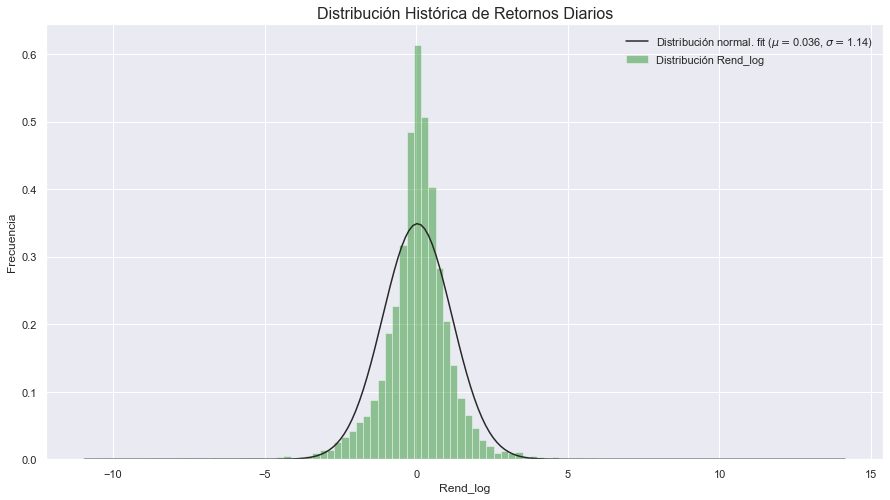

In [5]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm
 
# Eliminamos la primera fila del DF; Contiene un valor NaN en el cálculo del R. Aritmético.
# Mingo - Este comando recoge todas las lineas desde la 2º (la 1º es el 0)
df = df.iloc[1:] 
 
# Dibujamos el historgrama de frecuencias. 
plt.figure(figsize=(15,8))
sns.set(color_codes = True)
# Mingo - Aquí lo tenemos, esta operación se debería realizar con el rendmiento Logaritmico.
ax = sns.distplot(df['Rend_log'], bins=100, kde=False, fit=stats.norm, color='green')
 
# Obtenemos los parámetros ajustados de la distribución normal utilizados por SNS
# Jorge me ha pedido que saque los rend. Logaritmicos.
(mu, sigma) = stats.norm.fit(df['Rend_log'])
 
# Configuramos el título del gráfico, legendas y etiquetas.
plt.title('Distribución Histórica de Retornos Diarios',fontsize = 16)
plt.ylabel('Frecuencia')
plt.legend(["Distribución normal. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma), 
            "Distribución Rend_log"])

In [6]:
# Calculamos la Tasa de Crecimiento Anual Compuesto y el resultado de Comprar y mantener.
# Mingo - Y está más claramente, no se pueden sumar los rendimientos airmeticos para sacar 
# rendmientos en otras escalas temporales, haremos la prueba con un RESAMPLE (ejercicio 1)
Años  = df["Rend_log"].count() / 252
# Mingo - Este dato si que lo calcula bien, compara el primer dato = iloc[0] con el último iloc[-1] 
# ( "-" hace que empiece por detrás), utilizando el precio, y no sumando rendmientos diarios o anuales
CAGR = (df['Adj Close'].iloc[-1]/ df['Adj Close'].iloc[0]) ** (1 / (Años - 1)) - 1
print('> Tasa de Crecimiento Anual Compuesto:','%.6s' % (100 * CAGR) ,'%')
print('> Buy & Hold:', '%.6s' % (100*(df['Adj Close'].iloc[-1]/ df['Adj Close'].iloc[0])),'%')
 
# Calculamos el Máximo Drawdown.
# Mingo - Ejercicio Nº, sacar gráfico de DD
Maximo_Anterior = df["Adj Close"].cummax()
drawdowns = 100*((df["Adj Close"] - Maximo_Anterior )/Maximo_Anterior )
DD = pd.DataFrame({"Adj Close": df["Adj Close"], 
                   "Previous Peak": Maximo_Anterior , 
                   "Drawdown": drawdowns})
print ('> Máximo Drawdown Histórico:', '%.6s' % np.min(DD['Drawdown']), '%') 
 
# Obtenemos el promedio, desviación típica, máximo y mínimo valor y número de datos analizados:
print ('> Media Diaria:', '%.6s' % (100 * df["Rend_log"].mean()),'%')
print ('> Desviación Típica Diaria:', '%.6s' % (100 * df["Rend_log"].std(ddof=1)),'%')
print ('> Máxima Pérdida Diaria:', '%.6s' % (100 * df["Rend_log"].min()),'%')
print ('> Máximo Beneficio Diario:', '%.6s' % (100 * df["Rend_log"].max()),'%')
print ('> Dias Analizados:', '%.6s' % df["Rend_log"].count())
print('<-------------------------------------------------->')
 
# Coeficiente de asimetria y curtosis de la distribución.
print ('> Coeficiente de Asimetría:', '%.6s' % df["Rend_log"].skew())
print ('> Curtosis:', '%.6s' % df["Rend_log"].kurt())
print('<-------------------------------------------------->')
 
# VaR Teórico obtenido a través de la distribución normal al 95% y 99% de confianza.
print('> VaR Modelo Gaussiano NC-95% :' , '%.6s' % (100 * norm.ppf(0.05, mu, sigma)),'%')
print('> VaR Modelo Gaussiano NC-99% :' , '%.6s' % (100 * norm.ppf(0.01, mu, sigma)),'%')
print('> VaR Modelo Gaussiano NC-99.7% :' , '%.6s' % (100 * norm.ppf(0.003, mu, sigma)),'%')
 
# VaR histórico al 95% y 99% de confianza.
print('> VaR Modelo Historico NC-95% :', '%.6s' % (100 * np.percentile(df["Rend_log"],5)),'%')
print('> VaR Modelo Historico NC-99% :', '%.6s' % (100 * np.percentile(df["Rend_log"],1)),'%')
print('> VaR Modelo Historico NC-99.7% :', '%.6s' % (100 * np.percentile(df["Rend_log"],.3)),'%')
print(DD)

> Tasa de Crecimiento Anual Compuesto: 9.9438 %
> Buy & Hold: 1157.6 %
> Máximo Drawdown Histórico: -55.18 %
> Media Diaria: 3.6372 %
> Desviación Típica Diaria: 114.33 %
> Máxima Pérdida Diaria: -1036. %
> Máximo Beneficio Diario: 1355.7 %
> Dias Analizados: 6762
<-------------------------------------------------->
> Coeficiente de Asimetría: -0.144
> Curtosis: 10.363
<-------------------------------------------------->
> VaR Modelo Gaussiano NC-95% : -184.4 %
> VaR Modelo Gaussiano NC-99% : -262.3 %
> VaR Modelo Gaussiano NC-99.7% : -310.5 %
> VaR Modelo Historico NC-95% : -182.2 %
> VaR Modelo Historico NC-99% : -314.9 %
> VaR Modelo Historico NC-99.7% : -466.6 %
             Adj Close  Previous Peak  Drawdown
Date                                           
1993-02-03   27.113388      27.113388  0.000000
1993-02-04   27.226835      27.226835  0.000000
1993-02-05   27.207933      27.226835 -0.069424
1993-02-08   27.207933      27.226835 -0.069424
1993-02-09   27.018862      27.226835

In [9]:
DD.head()

,Adj Close,Previous Peak,Drawdown
Date,,,
1993-02-03,27.113388,27.113388,0.000000
1993-02-04,27.226835,27.226835,0.000000
1993-02-05,27.207933,27.226835,-0.069424
1993-02-08,27.207933,27.226835,-0.069424
1993-02-09,27.018862,27.226835,-0.763855


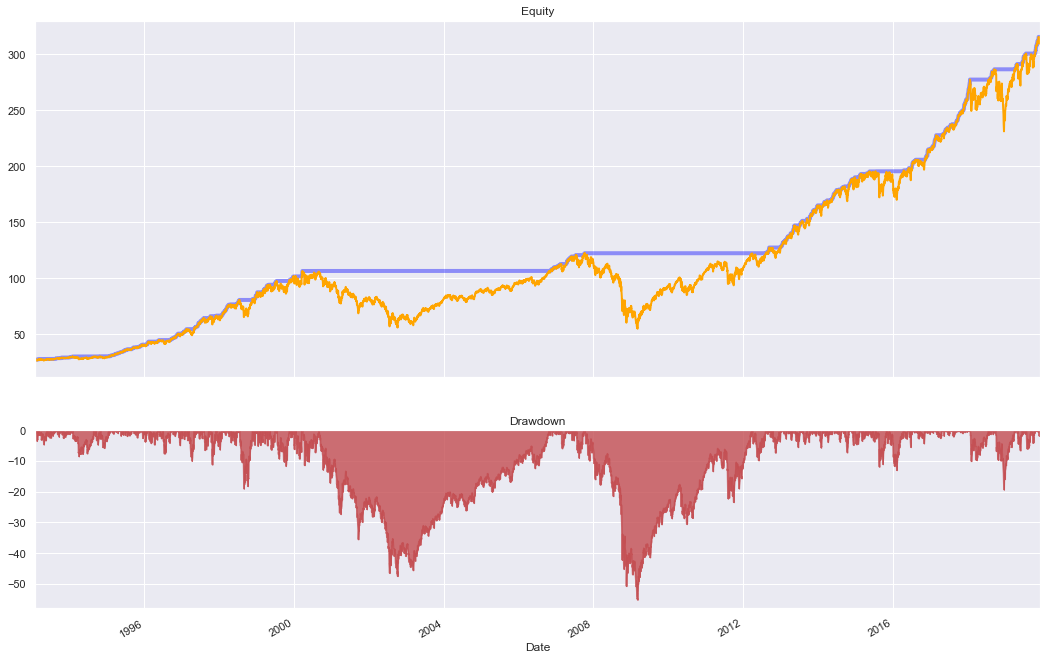

In [10]:
# Mingo - Graficamos el equity y el drawdown del sistema
# Tengo guardados ejemplo de gráficos interactivos, cuando lo encuentre y los 
# pueda integrar, los empezmos a utilizar para pdoer ver datos sobre el gráfico.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(18, 12),
                               gridspec_kw={'height_ratios': [4, 2]})
#data.equity.plot(ax=ax1, title='Equity', linewidth=8, alpha=0.4, c='b')
DD["Previous Peak"].plot(ax=ax1, title='Equity vs Watermark', linewidth=4, alpha=0.4, c='blue')
DD["Adj Close"].plot(ax=ax1, title='Equity', linewidth=2, c='orange')
DD.Drawdown.plot.area(ax=ax2, color='r', title='Drawdown', alpha=0.8);

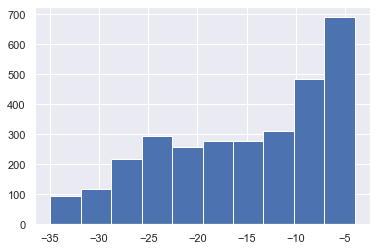

In [15]:
# Aquí solo pretendo crear un histograma para ver en que punto se empiezan a reducir los DD
# Claramente del -10'% (recordad, de momento logaritmico) le cuesta bajar, y hasta el -25%
# es estable. Probad a jugar con estos valores (-4 y -35 en el original). 
#df.query('Open>15 and Volume>10**8')
#df.query('index > 2019 and Rend_log> 0')
#DD.Drawdown.hist(bins=323, histtype='step')
#len(DD.Drawdown.resample('M'))
#DD.count()
DD.query('Drawdown < -4 and Drawdown > -35 ').Drawdown.hist()

In [16]:
total = len(df)
rend_Pos = len(df[df["Rend_log"] > 0])
rel_Pos=rend_Pos*100/total
#print(rel_pos, "%")
rend_Neg = len(df[df["Rend_log"] < 0])
rel_Neg=rend_Neg*100/total
no_rend = len(df[df["Rend_log"] == 0])
rel_No = no_rend*100/total
print(" De %s días de mercado:" % total)
print(" Días Positivos: %s , %d" % (rend_Pos , rel_Pos),"%")
print(" Días Negativos: %s , %d" % (rend_Neg, rel_Neg),"%")
print(" Días Neutrales:  %s , %d" % (no_rend, rel_No),"%")
#len(df[df["Rend_log"] == 0])


 De 6762 días de mercado:
 Días Positivos: 3637 , 53 %
 Días Negativos: 3065 , 45 %
 Días Neutrales:  60 , 0 %


In [17]:
df.loc['20181005':'20181008']   # compruebo los rendimientos a 0

,High,Low,Open,Close,Volume,Adj Close,Rend_log
Date,,,,,,,
2018-10-05,290.269989,286.220001,289.690002,287.820007,105951700.0,282.211914,-0.561286
2018-10-08,288.220001,285.500000,287.049988,287.820007,87742200.0,282.211914,0.000000


In [18]:
fechaup = df['Rend_log'].idxmax()
print("La mayor subida es del %s" % round(df.Rend_log.max(),2),"%")
print("El día %s" % fechaup)

La mayor subida es del 13.56 %
El día 2008-10-13 00:00:00


In [19]:
print("El pejor día de mercado fue :")
round(df.loc[[df.Rend_log.idxmax()],'Adj Close':'Rend_log'],2)

El pejor día de mercado fue :


,Adj Close,Rend_log
Date,,
2008-10-13,80.84,13.56


In [20]:
fechadown = df['Rend_log'].idxmin()
print("La mayor bajada es del %s" % round(df.Rend_log.min(),2),"%")
print("El día %s" % fechadown)

La mayor bajada es del -10.36 %
El día 2008-10-15 00:00:00


In [21]:
print("El peor día de mercado fue :")
round(df.loc[[df.Rend_log.idxmin()],'Close':'Rend_log'],2)  #, san.loc['2015-11-01':'2015-11-10', 'Adj Close':'Volume'] 

El peor día de mercado fue :


,Close,Volume,Adj Close,Rend_log
Date,,,,
2008-10-15,90.02,484627500.0,71.81,-10.36


In [22]:
print("El peor día de mercado fue : ")
print(df['Rend_log'].sort_values(ascending=True)[0:1])

El peor día de mercado fue : 
Date
2008-10-15   -10.363702
Name: Rend_log, dtype: float64


In [23]:
print("Peores días de mercado por Rend Log:")
print(df['Rend_log'].sort_values(ascending=True)[0:9])
print("")
print("Pérdida de esos 10 días %s" % round(df['Rend_log'].sort_values(ascending=True)[0:9].sum(),2),"%")

Peores días de mercado por Rend Log:
Date
2008-10-15   -10.363702
2008-12-01    -9.274930
2008-09-29    -8.160255
2008-11-20    -7.713259
1997-10-27    -7.523355
1998-08-31    -7.401494
2008-10-09    -7.239716
2011-08-08    -6.734091
2008-11-19    -6.622462
Name: Rend_log, dtype: float64

Pérdida de esos 10 días -71.03 %


In [24]:
print("Mejores días de mercado por Rend Log:")
print(df['Rend_log'].sort_values(ascending=False)[0:9])
print("")
print("Ganancia de esos 10 días %s" % round(df['Rend_log'].sort_values(ascending=False)[0:9].sum(),2),"%")

Mejores días de mercado por Rend Log:
Date
2008-10-13    13.557723
2008-10-28    11.051711
2009-03-23     6.936691
2008-11-24     6.699562
2008-11-13     6.047371
2008-10-20     5.834396
2002-07-24     5.795015
2009-03-10     5.790034
2000-01-07     5.645201
Name: Rend_log, dtype: float64

Ganancia de esos 10 días 67.36 %


Date
0    0.031477
1    0.064859
2    0.045655
3    0.015926
4    0.022883
Name: Rend_log, dtype: float64


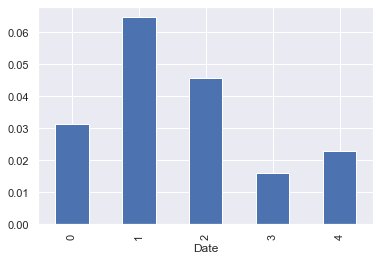

In [25]:
# Rendimientos por día de la semana y gráfico
print(df.Rend_log.groupby(df.index.dayofweek).mean())
media_semanal= df.Rend_log.groupby(df.index.dayofweek).mean().plot(kind='bar')

Date
1     0.031766
2     0.008463
3     0.064455
4     0.088795
5     0.028365
6     0.005743
7     0.038287
8    -0.019627
9    -0.003698
10    0.066030
11    0.086168
12    0.040907
Name: Rend_log, dtype: float64


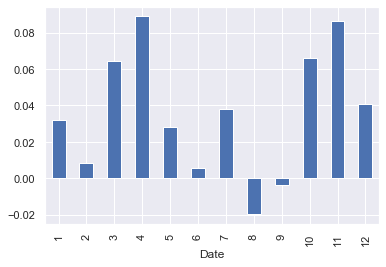

In [30]:
# Rendimientos por mes y gráfico
rend_mensuales = df.Rend_log.groupby(df.index.month).mean()  # solo pasé a base 100 los rend diarios
print(rend_mensuales)
df.Rend_log.groupby(df.index.month).mean().plot(kind='bar')

In [28]:
type(rend_mensuales)  # estas pruebas son una mamonada, pero ayuda saber cuando es una serie, un DF, una lista . . .

pandas.core.series.Series

In [39]:
# El sistema Halloween lo "maqueamos": eliminamos Agosto y septiembre que son los 2 únicos meses con el acumulado negativo
#
#rend_mensuales.sum()
print(" Rendmiento sin verano : ", (rend_mensuales[0:8].sum()+ rend_mensuales[9:12].sum()))
print(" Rendmiento anual completo : " , rend_mensuales.sum())
# Ya tenemos un sistema que mejora, por muy poco, el SPY= compramos SPY y en Agosto/septiembre vendemos futuros para "netear"
# la posición (es coña, la ganancia es mínima, lo ganado se perdería en comisiones y horquillas, pero descansaríamos en verano)

 Rendmiento sin verano :  0.4393513015998269
 Rendmiento anual completo :  0.43565350053254237


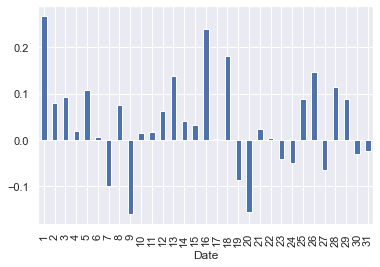

In [40]:
# Rendimientos por día del mes, ojo, Dias naturales. Sería interesante hacerlo por días de Trading y comparar
df.groupby([df.Rend_log.index.day]).Rend_log.mean().plot(kind='bar') #df.groupby ([df.index.day]).mean()

In [41]:
df.groupby([df.Rend_log.index.day]).Rend_log.cumsum()  # no sé que quería hacer aquí

Date
1993-02-03     1.051543
1993-02-04     0.417545
1993-02-05    -0.069448
1993-02-08     0.000000
1993-02-09    -0.697339
                ...    
2019-12-03    20.528669
2019-12-04     3.940879
2019-12-05    23.737243
2019-12-06     1.296882
2019-12-09   -36.568332
Name: Rend_log, Length: 6762, dtype: float64

In [42]:
df.groupby([df.Rend_log.index.day]).cumsum()  # esto está mal, fijaos que hace un acumulado de todas las columnas

,High,Low,Open,Close,Volume,Adj Close,Rend_log
Date,,,,,,,
1993-02-03,44.843750,44.375000,44.406250,44.812500,5.294000e+05,27.113388,1.051543
1993-02-04,45.093750,44.468750,44.968750,45.000000,5.315000e+05,27.226835,0.417545
1993-02-05,45.062500,44.718750,44.968750,44.968750,4.921000e+05,27.207933,-0.069448
1993-02-08,45.125000,44.906250,44.968750,44.968750,5.961000e+05,27.207933,0.000000
1993-02-09,44.812500,44.562500,44.812500,44.656250,1.221000e+05,27.018862,-0.697339
...,...,...,...,...,...,...,...
2019-12-03,30080.240601,29716.693710,29922.446846,29918.677422,1.785618e+10,24685.125589,20.528669
2019-12-04,28470.970589,28092.625031,28294.030624,28301.984352,1.809973e+10,23466.977386,3.940879
2019-12-05,30918.664421,30535.654381,30736.503792,30756.691895,1.857006e+10,25539.489513,23.737243


In [58]:
# ni idea de como he sacado esto, pero saca los días de Trading
df.groupby(pd.Grouper(freq='M')).cumcount()+1    

Date
1993-02-03    1
1993-02-04    2
1993-02-05    3
1993-02-08    4
1993-02-09    5
             ..
2019-12-03    2
2019-12-04    3
2019-12-05    4
2019-12-06    5
2019-12-09    6
Length: 6762, dtype: int64

In [59]:
# rendmiento acumulado por días
rend_dia_mes = df.groupby([df.index.day]).Rend_log.sum()
print(rend_dia_mes)

Date
1     55.178588
2     17.513454
3     20.528669
4      3.940879
5     23.737243
6      1.296882
7    -22.640192
8     17.552188
9    -36.568332
10     3.604679
11     4.164438
12    14.494895
13    31.089106
14     9.264518
15     7.035191
16    53.560418
17     0.366534
18    39.969934
19   -19.112069
20   -34.633284
21     5.252845
22     0.836182
23    -9.399071
24   -11.171691
25    17.771524
26    32.033033
27   -14.291218
28    25.106690
29    18.665346
30    -6.171035
31    -3.026489
Name: Rend_log, dtype: float64


In [60]:
# Ordenamos los rendimientos cumulados, el 1er día de mes el mas alcista, después días de enmedio y de finales
# Posible sistema, entrar el 27 al cierre (recoger la rentabilidad desde el 28) y salir el 5 al cierre
rend_dia_mes.sort_values(ascending=False)

Date
1     55.178588
16    53.560418
18    39.969934
26    32.033033
13    31.089106
28    25.106690
5     23.737243
3     20.528669
29    18.665346
25    17.771524
8     17.552188
2     17.513454
12    14.494895
14     9.264518
15     7.035191
21     5.252845
11     4.164438
4      3.940879
10     3.604679
6      1.296882
22     0.836182
17     0.366534
31    -3.026489
30    -6.171035
23    -9.399071
24   -11.171691
27   -14.291218
19   -19.112069
7    -22.640192
20   -34.633284
9    -36.568332
Name: Rend_log, dtype: float64

In [61]:
# Este proceso es hacer una suma de los rendmientos por el día de mes y luego sumar todos esos días. 
rend_dia_mes.sum() # 

245.94985609848985

In [62]:
# los 5 primeros días de mes (la suma de todos el historico) se hace la mitad del rendmiento del mes
rend_dia_mes[0:5].sum()

120.89883358441217

In [65]:
# esto es una prueba, suma de los renmdientos Log de toda la serie. soy un desconfiado, no me fio de los estudios de otros,
# ni de ls míos, ni de Python sus librerías y por supuesto, los servicios de datos.
df.Rend_log.sum()  

245.94985609848993

In [66]:
#Aquí compruebo, la difernecia entre el último número de la serie y el primero, no está en BASE % (*100)
np.log(df['Adj Close'][-1]) - np.log(df['Adj Close'][0]) # np.log(df["Adj Close"]) - np.log(df["Adj Close"].shift(1)

2.4489831325093445

In [67]:
print("1º cierre: %s " % df['Adj Close'][0])
print("Último cierre: %s " % df['Adj Close'][-1])

1º cierre: 27.113388061523438 
Último cierre: 313.8800048828125 


In [68]:
df.loc['2019-01-01':].Rend_log.cumsum() # Cuenta desde 2019-01-01 en adelante

Date
2019-01-02     0.103967
2019-01-03    -2.311236
2019-01-04     0.983466
2019-01-07     1.768834
2019-01-08     2.703982
                ...    
2019-12-03    22.783300
2019-12-04    23.398430
2019-12-05    23.578066
2019-12-06    24.487325
2019-12-09    24.172417
Name: Rend_log, Length: 237, dtype: float64

In [69]:
# Esta consulta la hago por que Tío Tino tiene un 40% de rentabilidad en /ES, quería saber , con datos de fin de día
# Si se hubiese acertado todos los dáis al alza y todos a la baja, cuando se hubiese sacado, poco más del +10%,
# pòr mis cojones que sus sistema está apalancado.
df.query("index > '2019-06' and index <'2019-07' and Rend_log > 0").Rend_log.sum() # Rendimiento Positivos de Junio 2019

8.646700393851248

In [70]:
df.query("index > '2019-06' and index <'2019-07' and Rend_log < 0").Rend_log.sum() # Rendimiento Negativos de Junio 2019

-1.9194893967380722

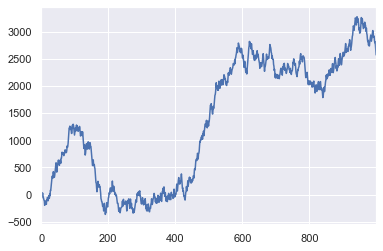

In [77]:
# Esta prueba viene de una hoja Excel que encontre hace una décata, metía, de forma aleatoria, rendmientos de -0.5% y +0.5%
# para generar una serie, y demostrar que en series aleatorias también se veían canales, dobles techos, ETC
s = pd.Series(np.random.randint(-100, 101, +1000))
s.cumsum().plot()

In [78]:
# compruebo cuantos días alcistas, bajistas y neutrales. Al principio los valores eran -1, 0 y +1 y salía 1/3 parte de días a 0
# quería dar pesos a esta distribución, pero voy cogiendo ingenio = como el randint(eger) solo genera números ewnteros, lo he 
# hecho de -100 (-1%) a +101( +1%) * el puto Paython, el  extremo inicial está incluido, el final no.
print(len(s[s>0]), ' Días positivos')
print(len(s[s<0]), ' Días Negativos')
print(len(s[s==0]), ' Días NEUTROS')

517  Días positivos
477  Días Negativos
6  Días NEUTROS


In [79]:
#Prueba generacion de rendmientos aleatorios, -1%, 0% ó+1%
# esto se lo dejo a Gines (funcionará el @Gines :-). Para no tener que ejecutar varias veces la generación aleatoria, 
# Crear un bucle que genere 10 ó 20 gráficos (que capullo soy, se podría utilizar  un range . . por lo menos me voy dando cuenta)
for a in b, c, d, e, f, g, h, i :
    a = pd.Series(np.random.randint(-100, 101, +1000))
    a.cumsum().plot()

NameError: name 'b' is not defined